# LLAMEA vs GA-LLAMEA: Prompt Comparison

Visualization of results from `../results/COMPARISON-PROMPTS`.\nComparison of:
- LLaMEA (Prompt 5: Refine, New, Simplify)
- LLaMEA (Prompt 1 Modified: Refine or redesign)
- GA-LLAMEA (Baseline)

This includes:
- Convergence Plots
- CEG Plots
- Boxplots
- Fitness Tables
- Behavior Metrics (with code projection)


In [3]:
from iohblade.loggers import ExperimentLogger
from iohblade.plots import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue, plot_boxplot_fitness, fitness_table
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Results
logger = ExperimentLogger('../results/COMPARISON-PROMPTS', True)
methods, problems = logger.get_methods_problems()
print("Methods:", methods)
print("Problems:", problems)

['LLaMEA-1', 'LLaMEA-2', 'LLaMEA-3', 'LLaMEA-4', 'LLaMEA-5']
['MA_BBOB']


In [7]:
plot_convergence(logger, metric="AOCC", save=True, budget=100)
plot_experiment_CEG(logger, save=True, budget=100, max_seeds=50)

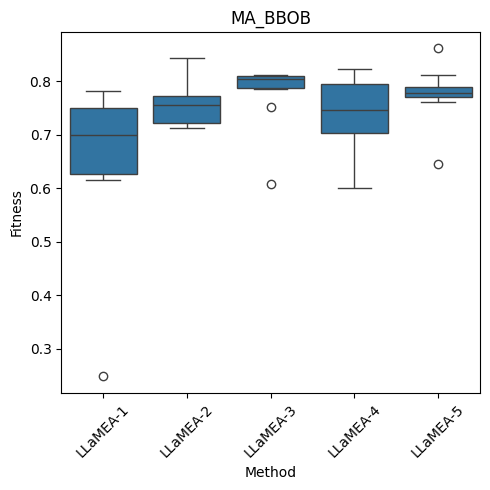

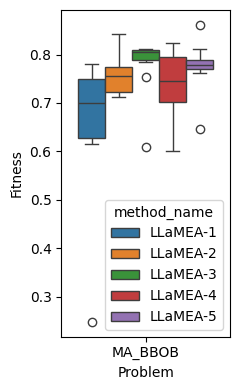

,MA_BBOB
LLaMEA-1,0.66 ± 0.15 (p=0.157)
LLaMEA-2,0.76 ± 0.04 (p=0.484)
LLaMEA-3,0.78 ± 0.06 (p=0.888)
LLaMEA-4,0.74 ± 0.06 (p=0.484)
LLaMEA-5,0.78 ± 0.05 (p=0.888)


In [4]:

plot_boxplot_fitness(logger)
plot_boxplot_fitness_hue(logger)

table_df = fitness_table(logger, alpha=0.05)
table_df
# Convert to LaTeX; escape=False so we can keep the \textbf{} markup
#latex_str = table_df.to_latex(escape=False)

In [6]:
"""Simple runner to analyze generated algorithms one by one on a wide benchmark set
"""
from ioh import get_problem, logger,LogInfo
import re
import os
import ioh
from tqdm.notebook import tqdm
from blade import OverBudgetException
from blade.utils import budget_logger
import numpy as np

#load MA_BBOB files
weights = pd.read_csv(
    os.path.join("blade", "problems", "mabbob", "weights.csv"), index_col=0
)
iids = pd.read_csv(
    os.path.join("blade", "problems", "mabbob", "iids.csv"), index_col=0
)
opt_locs = pd.read_csv(
    os.path.join("blade", "problems", "mabbob", "opt_locs.csv"), index_col=0
)

In [ ]:
# now we evaluate all best solutions using IOH

"""Simple runner to analyze generated algorithms one by one on a wide benchmark set
"""

if 'fitness' not in exp_data.columns:
    exp_data['fitness'] = exp_data['solution'].apply(lambda sol: sol.get('fitness', float('nan')))

# Group by (problem_name, method_name) and find the row with the best (lowest) fitness
best_rows = exp_data.loc[exp_data.groupby(['problem_name', 'method_name'])['fitness'].idxmax()]

for idx, row in best_rows.iterrows():
    
    solution_dict = row['solution']
    method_name = row['method_name']
    problem_name = row['problem_name']
    fitness = row['fitness']

    #algorithm_name = re.findall("try-\d*-(\w*)\.py", code_file, re.IGNORECASE)[0]
    algorithm_name = solution_dict["name"]
    alg = solution_dict["code"]
    print("Benchmarking", algorithm_name)

    for dim in [5]:
        budget = 2000 * dim
        
        loggers = [budget_logger(budget=budget, triggers=[logger.trigger.ALWAYS]), logger.Analyzer(folder_name=f"results/ioh-MABBOB/{method_name}", algorithm_name=method_name)]
        l1 = logger.Combine(loggers)

        for iid in tqdm(range(100, 150)):
            problem = ioh.problem.ManyAffine(
                xopt=np.array(opt_locs.iloc[iid])[:dim],
                weights=np.array(weights.iloc[iid]),
                instances=np.array(iids.iloc[iid], dtype=int),
                n_variables=dim,
            )
            problem.set_id(100)
            problem.set_instance(iid)
            problem.attach_logger(l1)
            for rep in range(5):
                np.random.seed(rep)
                try:
                    safe_globals = {"np": np}
                    local_env = {}
                    exec(alg, safe_globals, local_env)
                    algorithm = local_env[algorithm_name](budget=budget, dim=dim)
                    algorithm(problem)
                except OverBudgetException:
                    pass
                except Exception:
                    pass
                problem.reset()
    with open(f'results/ioh-MABBOB/{method_name}.py', 'w', encoding='utf-8') as f:
        f.write(alg)



Benchmarking CMAES_OLS_Mirrored


  0%|          | 0/50 [00:00<?, ?it/s]

Benchmarking DynamicPopulationDE


  0%|          | 0/50 [00:00<?, ?it/s]

Benchmarking AdaptiveDE


  0%|          | 0/50 [00:00<?, ?it/s]

Benchmarking AdaptiveDEwithSelfAdaptiveLocalSearchImproved


  0%|          | 0/50 [00:00<?, ?it/s]

Benchmarking NeighborhoodAdaptiveDE


  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
# add baseline CMAES
from blade.baselines.modcma import ModularCMAES
method_name = "baseline CMA-ES"

for dim in [5]:
    budget = 2000 * dim
    
    loggers = [budget_logger(budget=budget, triggers=[logger.trigger.ALWAYS]), logger.Analyzer(folder_name=f"results/ioh-MABBOB/{method_name}", algorithm_name=method_name)]
    l1 = logger.Combine(loggers)

    for iid in tqdm(range(100, 150)):
        problem = ioh.problem.ManyAffine(
            xopt=np.array(opt_locs.iloc[iid])[:dim],
            weights=np.array(weights.iloc[iid]),
            instances=np.array(iids.iloc[iid], dtype=int),
            n_variables=dim,
        )
        problem.set_id(100)
        problem.set_instance(iid)
        problem.attach_logger(l1)
        for rep in range(5):
            np.random.seed(rep)
            try:
                algorithm = ModularCMAES(budget, dim)
                algorithm(problem)
            except OverBudgetException:
                pass
            problem.reset()

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
import iohinspector
import polars as pl
manager = iohinspector.DataManager()
manager.add_folder("../results/ioh-MABBOB")
df = manager.load(True, True)



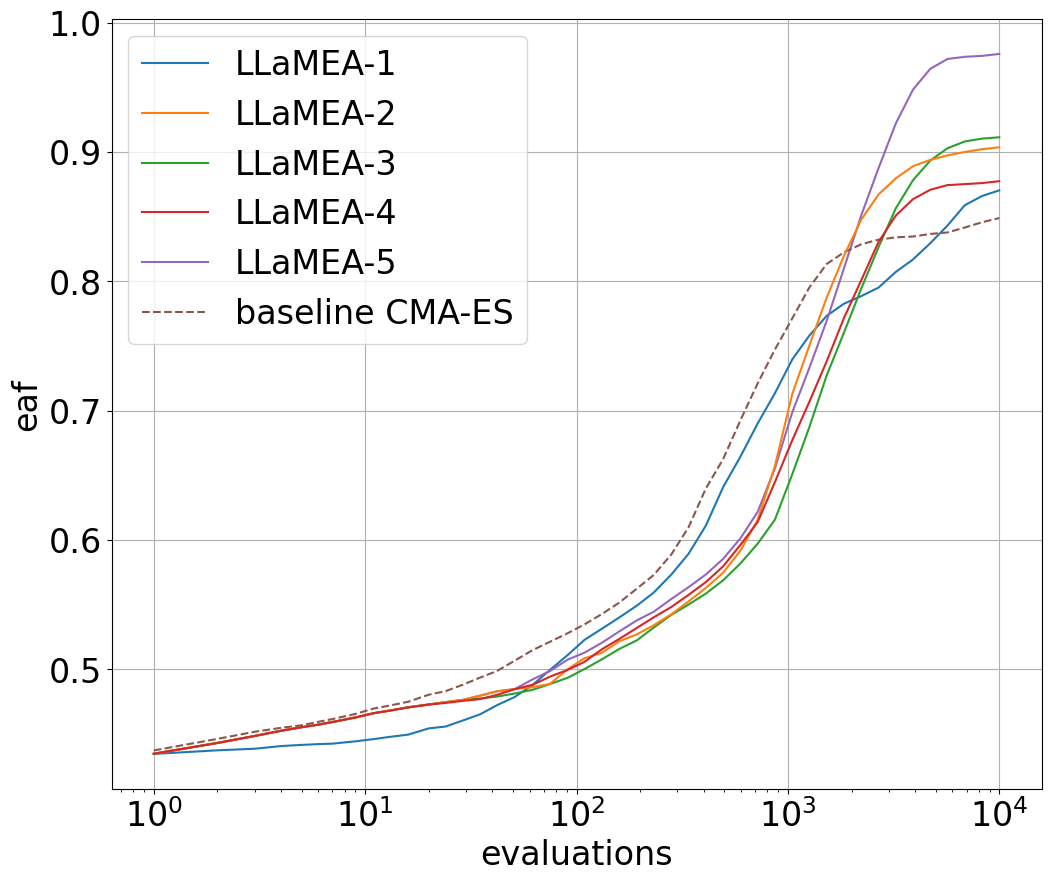

In [7]:
import operator
custom_color_map = {
    "LLaMEA-1": "C0",
    "LLaMEA-2": "C1",
    "LLaMEA-3": "C2",
    "LLaMEA-4": "C3",
    "LLaMEA-5" :"C4",
    "baseline CMA-ES" :"C5",
    # etc.
}

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 5), y_max=100, y_min=1e-8, ax=ax, scale_xlog=True)
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Also get the lines (the actual plot objects) in the order they were created.
# Usually, ax.lines matches up with the unique hue levels in the same order
lines = ax.lines

# Make a mapping from label -> line object
label_to_line = dict(zip(labels, lines))

for handle, label in zip(handles, labels):
    # For bar charts, the handles are Rectangle patches
    handle.set_color(custom_color_map[label])
    if label == "baseline CMA-ES":
        handle.set_linestyle("--")
    else:
        handle.set_linestyle("-")

for label, line in label_to_line.items():
    # Set the color/linestyle on the actual plot line
    line.set_color(custom_color_map.get(label, 'black'))
    if label == "baseline CMA-ES":
        line.set_linestyle("--")
    else:
        line.set_linestyle("-")

# Sort them alphabetically (by label)
sorted_pairs = sorted(zip(labels, handles), key=operator.itemgetter(0))
sorted_labels, sorted_handles = zip(*sorted_pairs)

# Clear the old legend and create a new one in sorted order
ax.legend(sorted_handles, sorted_labels)
plt.show()

In [14]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""baseline CMA-ES""",0.70778
"""LLaMEA-4""",0.717198
"""LLaMEA-2""",0.759521
"""LLaMEA-1""",0.698703
"""LLaMEA-3""",0.742359
"""LLaMEA-5""",0.837403


<Figure size 1200x700 with 0 Axes>

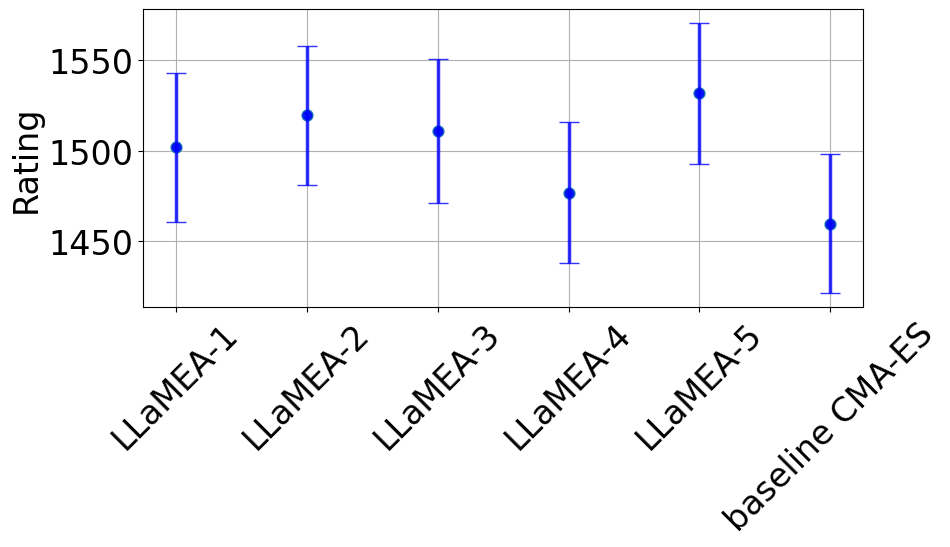

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 7))
dt_elo = iohinspector.plot.plot_tournament_ranking(df, nrounds=100000, ax=ax)
dt_elo_sorted = dt_elo.sort_values(by='algorithm_name')
plt.clf()
_, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.pointplot(data=dt_elo_sorted, x="algorithm_name", y="Rating", linestyle="none", ax=ax)

ax.errorbar(
    dt_elo_sorted["algorithm_name"],
    dt_elo_sorted["Rating"],
    yerr=dt_elo_sorted["Deviation"],
    fmt="o",
    color="blue",
    alpha=0.8,
    capsize=7,
    elinewidth=2.5,
)
ax.grid()

ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("")
plt.tight_layout()
plt.savefig("MA_BBOB-elo.png")